# 📌 Introdução

Neste arquivo vamos:

1- Importar a base de dados que raspamos;

2- Breve análise exploratória dos dados;

3- Ajustar um modelo que prevê o gasto calórico baseado nas variáveis disponíveis.

# 📥 Objetivo

Este documento realiza a modelagem dos dados de gasto calórico.

# 💻 Código

Instalando e Carregando os Pacotes necessários


In [3]:
if (!require(tidyverse)) install.packages("tidyverse")
if (!require(broom)) install.packages("broom")
if (!require(ggthemes)) install.packages("ggthemes")
if (!require(patchwork)) install.packages("patchwork")


In [4]:
dados <- read.csv2("../datas/dados_raspados.csv", sep = ",")



Vamos checar se existe uma relação linear com o peso e caloria para poder classificar as atividades como leve, moderada e intensa se baseando nos gastos calóricos, pois, se nos basearmos apenas nos dados brutos para a classificação, assumimos que o peso não afeta no gasto.



In [13]:
modelos <- dados |> 
  group_by(atividade) |> 
  nest() |> 
  mutate(
    modelo = map(data, ~ lm(caloria ~ peso, data = .x)), # Modelo de regressão linear simples para cada atividade de acordo com # o peso, montam então 249 modelos.
    metrics = map(modelo, glance) 
  ) |> 
  unnest(metrics)  

modelos <- modelos |> 
  mutate(
    calorias_70kg = map_dbl(modelo, ~ predict(.x, newdata = tibble(peso = 70))),
    calorias_59kg = map_dbl(modelo, ~ predict(.x, newdata = tibble(peso = 59))), # Aplica o modelo nos pesos
    calorias_82kg = map_dbl(modelo, ~ predict(.x, newdata = tibble(peso = 82))),
    calorias_93kg = map_dbl(modelo, ~ predict(.x, newdata = tibble(peso = 93)))
  )

summary(modelos$r.squared)
summary(modelos$p.value)

saveRDS(modelos, "../modelos/modelos_calorias.rds")


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9993  0.9997  0.9997  0.9997  0.9997  0.9999 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
7.435e-05 1.323e-04 1.539e-04 1.543e-04 1.739e-04 3.482e-04 

Os modelos ficaram ótimos



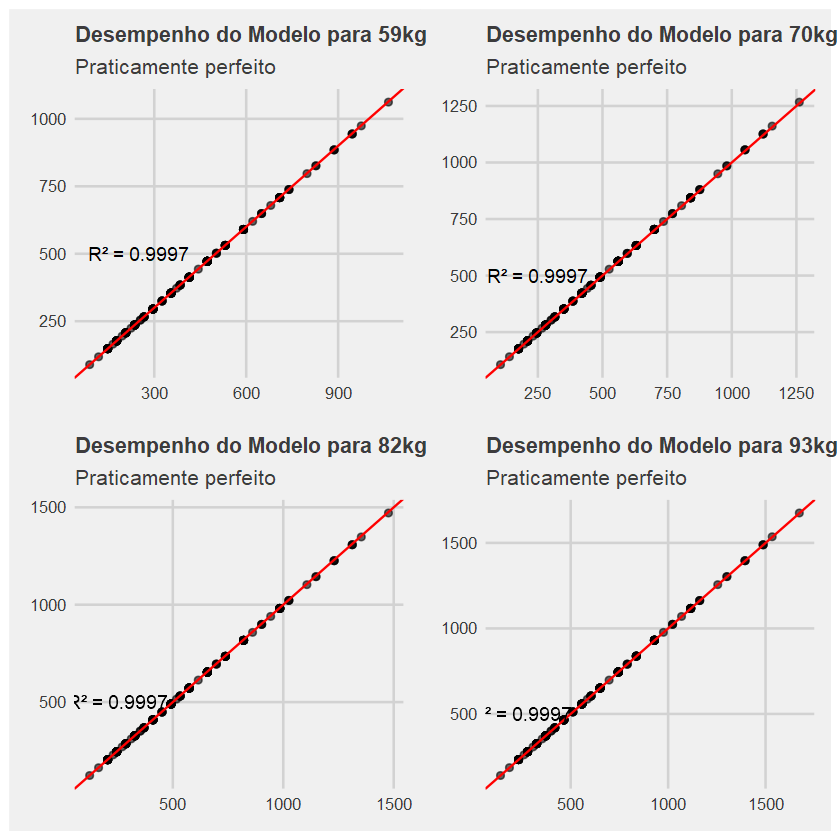

In [6]:
g1 <- data.frame(
  real = dados |> 
    filter(peso == 59) |> 
    select(caloria),
  preditivo = modelos$calorias_59kg
) |> 
  ggplot(aes(x = preditivo, y = caloria)) +
  geom_point(alpha = .6) +
  geom_abline(slope = 1,
              intercept = 0,
              color = "red",
              linewidth = 0.5) +
  annotate(
    "text", 
    x = 250, 
    y = 500,
    label = paste("R² =", round(mean(modelos$r.squared),4))
  ) +
  labs(
    title = "Desempenho do Modelo para 59kg",
    subtitle = "Praticamente perfeito"
  ) +
  theme_fivethirtyeight() +
  theme(plot.title = element_text(size = 13), 
        plot.margin = margin(10, 10, 10, 10)) 

g2 <- data.frame(
  real = dados |> 
    filter(peso == 70) |> 
    select(caloria),
  preditivo = modelos$calorias_70kg
) |> 
  ggplot(aes(x = preditivo, y = caloria)) +
  geom_point(alpha = .6) +
  geom_abline(slope = 1,
              intercept = 0,
              color = "red",
              linewidth = 0.5) +
  annotate(
    "text", 
    x = 250, 
    y = 500,
    label = paste("R² =", round(mean(modelos$r.squared),4))
  ) +
  labs(
    title = "Desempenho do Modelo para 70kg",
    subtitle = "Praticamente perfeito"
  ) +
  theme_fivethirtyeight() +
  theme(plot.title = element_text(size = 13), 
        plot.margin = margin(10, 10, 10, 10))


g3 <- data.frame(
  real = dados |> 
    filter(peso == 82) |> 
    select(caloria),
  preditivo = modelos$calorias_82kg
) |> 
  ggplot(aes(x = preditivo, y = caloria)) +
  geom_point(alpha = .6) +
  geom_abline(slope = 1,
              intercept = 0,
              color = "red",
              linewidth = 0.5) +
  annotate(
    "text", 
    x = 250, 
    y = 500,
    label = paste("R² =", round(mean(modelos$r.squared),4))
  ) +
  labs(
    title = "Desempenho do Modelo para 82kg",
    subtitle = "Praticamente perfeito"
  ) +
  theme_fivethirtyeight() +
  theme(plot.title = element_text(size = 13), 
        plot.margin = margin(10, 10, 10, 10))

g4 <- data.frame(
  real = dados |> 
    filter(peso == 93) |> 
    select(caloria),
  preditivo = modelos$calorias_93kg
) |> 
  ggplot(aes(x = preditivo, y = caloria)) +
  geom_point(alpha = .6) +
  geom_abline(slope = 1,
              intercept = 0,
              color = "red",
              linewidth = 0.5) +
  annotate(
    "text", 
    x = 250, 
    y = 500,
    label = paste("R² =", round(mean(modelos$r.squared),4))
  ) +
  labs(
    title = "Desempenho do Modelo para 93kg",
    subtitle = "Praticamente perfeito"
  ) +
  theme_fivethirtyeight() +
  theme(plot.title = element_text(size = 13), 
        plot.margin = margin(10, 10, 10, 10))

(g1 | g2) /
(g3 | g4)


Conclui-se que, existe uma grande relação linear entre o peso e o gasto calórico

Vamos fixar um peso como base de 70kg e nos basear no gasto calórico dos exercícios apenas


In [7]:
limiares <- dados |> 
  filter(peso == 70) |> 
  summarise(
    q25 = quantile(caloria, 0.25),
    q75 = quantile(caloria, 0.75)
  )

dados <- dados |> 
  mutate(
    categoria = case_when(
      caloria <= limiares$q25 ~ "leve",
      caloria >= limiares$q75 ~ "intenso",
      TRUE ~ "moderado" 
    )
  )


Criando uma variável *atividade_micro* para categorizar que tipo de exercício se trata



In [8]:
dados <- dados |> 
  mutate(atividade_micro = case_when(
    str_detect(atividade, regex("cycling", ignore_case = T)) ~ "Ciclismo",
    str_detect(atividade, regex("calisthenics", ignore_case = T)) ~ "Calistenia",
    str_detect(atividade, regex("circuit", ignore_case = T)) ~ "Circuito",
    str_detect(atividade, regex("weight lifting|resistance|health club", ignore_case = TRUE)) ~ "Musculação",
    str_detect(atividade, regex("stair", ignore_case = TRUE)) ~ "Escada",
    str_detect(atividade, regex("rowing", ignore_case = TRUE)) ~ "Remo",
    str_detect(atividade, regex("ski|skiing", ignore_case = TRUE)) ~ "Esqui",
    str_detect(atividade, regex("aerobics", ignore_case = TRUE)) ~ "Aeróbico",
    str_detect(atividade, regex("aerobic", ignore_case = TRUE)) ~ "Aeróbico",
    str_detect(atividade, regex("jazzercise|ballet|ballroom", ignore_case = TRUE)) ~ "Dança",
    str_detect(atividade, regex("yoga|stretching", ignore_case = TRUE)) ~ "Yoga",
    str_detect(atividade, regex("track and field", ignore_case = TRUE)) ~ "Atletismo",
    str_detect(atividade, regex("archery", ignore_case = TRUE)) ~ "Tiro com arco",
    str_detect(atividade, regex("badminton", ignore_case = TRUE)) ~ "Badminton",
    str_detect(atividade, regex("basketball", ignore_case = TRUE)) ~ "Basquete",
    str_detect(atividade, regex("billiards", ignore_case = TRUE)) ~ "Sinuca",
    str_detect(atividade, regex("bowling", ignore_case = TRUE)) ~ "Boliche",
    str_detect(atividade, regex("boxing|martial arts|krav maga|tai chi|wrestling", ignore_case = TRUE)) ~ "Luta",
    str_detect(atividade, regex("coaching|exercise class", ignore_case = TRUE)) ~ "Treinador",
    str_detect(atividade, regex("cricket", ignore_case = TRUE)) ~ "Críquete",
    str_detect(atividade, regex("Croquet", ignore_case = TRUE)) ~ "Cróquete",
    str_detect(atividade, regex("curling", ignore_case = TRUE)) ~ "Curling",
    str_detect(atividade, regex("darts", ignore_case = TRUE)) ~ "Dardos",
    str_detect(atividade, regex("fencing", ignore_case = TRUE)) ~ "Esgrima",
    str_detect(atividade, regex("football", ignore_case = TRUE)) ~ "Futebol americano",
    str_detect(atividade, regex("frisbee", ignore_case = TRUE)) ~ "Frisbee",
    str_detect(atividade, regex("golf", ignore_case = TRUE)) ~ "Golfe",
    str_detect(atividade, regex("gymnastics", ignore_case = TRUE)) ~ "Ginástica",
    str_detect(atividade, regex("hacky sack", ignore_case = TRUE)) ~ "Footbag",
    str_detect(atividade, regex("handball", ignore_case = TRUE)) ~ "Handebol",
    str_detect(atividade, regex("hockey", ignore_case = TRUE)) ~ "Hóquei",
    str_detect(atividade, regex("horse", ignore_case = TRUE)) ~ "Hipismo",
    str_detect(atividade, regex("jai alai", ignore_case = TRUE)) ~ "Jai alai",
    str_detect(atividade, regex("juggling", ignore_case = TRUE)) ~ "Malabarismo",
    str_detect(atividade, regex("kickball", ignore_case = TRUE)) ~ "Kickball",
    str_detect(atividade, regex("lacrosse", ignore_case = TRUE)) ~ "Lacrosse",
    str_detect(atividade, regex("orienteering", ignore_case = TRUE)) ~ "Orientação",
    str_detect(atividade, regex("paddleball", ignore_case = TRUE)) ~ "Padel",
    str_detect(atividade, regex("polo", ignore_case = TRUE)) ~ "Polo",
    str_detect(atividade, regex("racquetball", ignore_case = TRUE)) ~ "Raquetebol",
    str_detect(atividade, regex("climbing", ignore_case = TRUE)) ~ "Escalada",
    str_detect(atividade, regex("jumping rope", ignore_case = TRUE)) ~ "Pular corda",
    str_detect(atividade, regex("rugby", ignore_case = TRUE)) ~ "Rugby",
    str_detect(atividade, regex("shuffleboard", ignore_case = TRUE)) ~ "Shuffleboard",
    str_detect(atividade, regex("skateboarding", ignore_case = TRUE)) ~ "Skate",
    str_detect(atividade, regex("roller skating|roller blading|ice skating|speed skating, ice", ignore_case = TRUE)) ~ "Patinação",
    str_detect(atividade, regex("sky diving", ignore_case = TRUE)) ~ "Paraquedismo",
    str_detect(atividade, regex("soccer", ignore_case = TRUE)) ~ "Futebol",
    str_detect(atividade, regex("sofball|baseball", ignore_case = TRUE)) ~ "Beisebol",
    str_detect(atividade, regex("squash", ignore_case = TRUE)) ~ "Squash",
    str_detect(atividade, regex("tennis", ignore_case = TRUE)) ~ "Tênis",
    str_detect(atividade, regex("trampoline", ignore_case = TRUE)) ~ "Trampolim",
    str_detect(atividade, regex("volleyball", ignore_case = TRUE)) ~ "Vôlei",
    str_detect(atividade, regex("backpacking|hiking", ignore_case = TRUE)) ~ "Trilha",
    str_detect(atividade, regex("carrying infant|carrying small children", ignore_case = TRUE)) ~ "Segurar bebê",
    str_detect(atividade, regex("carrying 16 to 24 lbs|carrying 25 to 49 lbs", ignore_case = TRUE)) ~ "Carregar peso",
    str_detect(atividade, regex("playing with children", ignore_case = TRUE)) ~ "Brincar com criança",
    str_detect(atividade, regex("loading car", ignore_case = TRUE)) ~ "Encher o carro",
    str_detect(atividade, regex("climbing hills", ignore_case = TRUE)) ~ "Subir um morro",
    str_detect(atividade, regex("downstairs", ignore_case = TRUE)) ~ "Descer escadas",
    str_detect(atividade, regex("bird watching", ignore_case = TRUE)) ~ "Assistir pássaros",
    str_detect(atividade, regex("marching", ignore_case = TRUE)) ~ "Marchar",
    str_detect(atividade, regex("dodgeball", ignore_case = TRUE)) ~ "Queimada",
    str_detect(atividade, regex("walking", ignore_case = TRUE)) ~ "Caminhada",
    str_detect(atividade, regex("pushing a wheelchair", ignore_case = TRUE)) ~ "Empurrar cadeira de rodas",
    str_detect(atividade, regex("canoeing|kayaking|paddle boat|sailing|boating", ignore_case = TRUE)) ~ "Canoa",
    str_detect(atividade, regex("diving|snorkeling", ignore_case = TRUE)) ~ "Mergulhar",
    str_detect(atividade, regex("surfing", ignore_case = TRUE)) ~ "Surfar",
    str_detect(atividade, regex("swimming", ignore_case = TRUE)) ~ "Nadar",
    str_detect(atividade, regex("sledding", ignore_case = TRUE)) ~ "Trenó",
    str_detect(atividade, regex("snow shoeing", ignore_case = TRUE)) ~ "Raquete de neve",
    str_detect(atividade, regex("snowmobiling", ignore_case = TRUE)) ~ "Moto de neve",
    str_detect(atividade, regex("housework|cleaning gutters|painting|mowing lawn|snow blower|shoveling snow by hand|raking lawn|gardening|bagging grass|garden|carpentry|carrying heavy loads|carrying moderate loads upstairs|cleaning|taking out trash", ignore_case = TRUE)) ~ "Cuidar da casa",
    str_detect(atividade, regex("playing with animals", ignore_case = TRUE)) ~ "Brincar com pet",
    str_detect(atividade, regex("bathing dog", ignore_case = TRUE)) ~ "Dar banho no cachorro",
    str_detect(atividade, regex("running|jogging", ignore_case = TRUE)) ~ "Corrida",
    str_detect(atividade, regex("softball", ignore_case = TRUE)) ~ "Softball",
    str_detect(atividade, regex("wallyball", ignore_case = TRUE)) ~ "Wallyball"
  ))

dados[is.na(dados$atividade_micro),]


atividade,peso,caloria,categoria,atividade_micro
<chr>,<int>,<int>,<chr>,<chr>


Criando e salvando o modelo



In [14]:
modelo_geral <- lm(caloria ~ peso + atividade + categoria,data = dados)

saveRDS(modelo_geral, "../modelos/modelo_geral.rds")


Criando as funções necessárias



In [10]:
library(tidyverse)

prever_calorias <- function(modelo, peso, atividade, tempo_minutos = 60) {
  # Obter a categoria correspondente à atividade selecionada
  categoria_atividade <- dados %>%
    filter(atividade == atividade) %>%
    pull(categoria) %>%
    first()
  
  nova_obs <- data.frame(
    peso = peso,
    atividade = atividade,
    categoria = categoria_atividade
  )
  
  # Previsão usando o modelo
  caloria_prevista_total <- predict(modelo, newdata = nova_obs)
  
  # Ajusta pelo tempo informado
  caloria_prevista_final <- caloria_prevista_total * (tempo_minutos / 60)
  
  return(caloria_prevista_final)
}

recomendar_atividades <- function(dados, categoria_filtrada = NULL, top_n = 5) {
  dados_filtrados <- dados %>%
    mutate(calorias_por_minuto = caloria / 60) %>%
    filter(peso == 70)  # Peso médio para recomendações
  
  if (!is.null(categoria_filtrada)) {
    dados_filtrados <- dados_filtrados %>%
      filter(categoria == categoria_filtrada)
  }
  
  recomendacoes <- dados_filtrados %>%
    arrange(desc(calorias_por_minuto)) %>%
    distinct(atividade, .keep_all = TRUE) %>%
    slice_head(n = top_n) %>%
    select(atividade, calorias_por_minuto, atividade_micro)
  
  return(recomendacoes)
}


E por fim, salvando os dados tratados



In [12]:
write_csv2(dados, "../datas/dados_limpos.csv")



Podemos continuar com o projeto.

